In [1]:
import torch
import torch.nn as nn
import numpy as np

In [41]:
# MNIST Training, Conv -> Batch -> Activation -> Pooling
import torch.nn.functional as F

class MNIST_Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(8)

        self.fc1 = nn.Linear(8 * 7 * 7, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = F.max_pool2d(F.relu(self.batch_norm1(x)), 2)

        x = self.conv2(x)
        x = F.max_pool2d(F.relu(self.batch_norm2(x)), 2)

        x = torch.flatten(x, 1, -1)
        x = self.fc1(x)

        return x
    
model = MNIST_Net()

In [42]:
import torchvision
from torch.utils.data import DataLoader

trainset = torchvision.datasets.MNIST('./ds', True, torchvision.transforms.ToTensor())
valset = torchvision.datasets.MNIST('./ds', False, torchvision.transforms.ToTensor())

trainloader = DataLoader(trainset, 32, True)
valloader = DataLoader(valset, 32, True)

len(trainloader), len(valloader)

(1875, 313)

In [45]:
import torch.optim as optim
import time

model = MNIST_Net()
model.train()

optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

epochs = 15

for i in range(1, epochs+1):

    s = time.time()
    running_loss = 0.0
    running_val_loss = 0.0

    model.train()
    for imgs, labels in trainloader:
        outs = model(imgs)

        loss = loss_fn(outs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    for imgs, labels in valloader:
        with torch.no_grad():
            outs = model(imgs)
            loss = loss_fn(outs, labels)

        running_val_loss += loss.item()
    
    f = time.time()

    print("Epoch {}, Train Loss {:3.4f}, Val Loss {:3.4f}, Time {:3.2f}".format(i, 
                                                                                running_loss / len(trainloader),
                                                                                running_val_loss / len(valloader),
                                                                                f - s),)

Epoch 1, Train Loss 0.8168, Val Loss 0.3505, Time 9.73
Epoch 2, Train Loss 0.2837, Val Loss 0.2144, Time 9.56
Epoch 3, Train Loss 0.1984, Val Loss 0.1629, Time 9.39
Epoch 4, Train Loss 0.1592, Val Loss 0.1344, Time 9.33
Epoch 5, Train Loss 0.1362, Val Loss 0.1167, Time 9.69
Epoch 6, Train Loss 0.1216, Val Loss 0.1044, Time 9.68
Epoch 7, Train Loss 0.1108, Val Loss 0.0961, Time 10.42
Epoch 8, Train Loss 0.1020, Val Loss 0.0900, Time 10.23
Epoch 9, Train Loss 0.0957, Val Loss 0.0852, Time 9.98
Epoch 10, Train Loss 0.0907, Val Loss 0.0807, Time 9.87
Epoch 11, Train Loss 0.0859, Val Loss 0.0778, Time 9.61
Epoch 12, Train Loss 0.0822, Val Loss 0.0729, Time 10.06
Epoch 13, Train Loss 0.0786, Val Loss 0.0702, Time 9.74
Epoch 14, Train Loss 0.0755, Val Loss 0.0672, Time 9.93
Epoch 15, Train Loss 0.0728, Val Loss 0.0652, Time 9.67


In [88]:
wrongs = []
model_pred = []

model.eval()
for i, (img, label) in enumerate(valset):
    out = model(img.unsqueeze(0))
    pred = torch.argmax(out).item()

    if pred != label:
        wrongs.append(i)
        model_pred.append(pred)

In [87]:
len(valset)

10000

[]

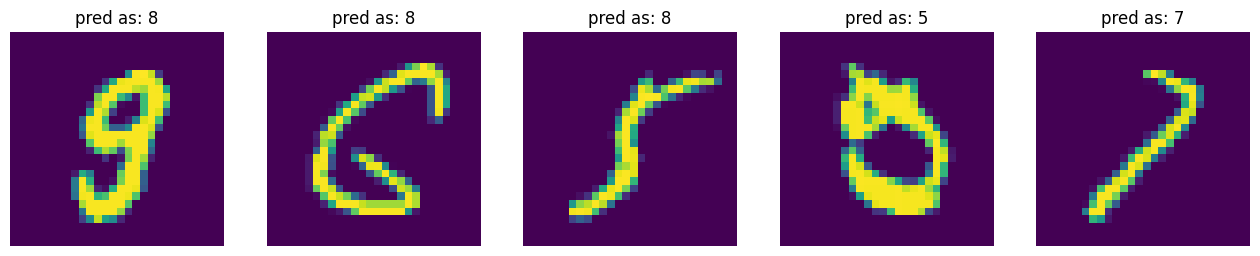

In [126]:
import random
import matplotlib.pyplot as plt

to_plot = random.sample(wrongs, 5)

fig, ax = plt.subplots(1, 5, figsize=(16, 16))

for i in range(5):

    idx = to_plot[i]
    pred = model_pred[i]

    ax[i].imshow(valset[idx][0].permute(1, 2, 0))
    ax[i].axis('off')
    ax[i].set_title(f"pred as: {pred}")

plt.plot()



In [127]:
torch.save(model.state_dict(), './models/mnist_net.pt')

In [149]:
model_opt = MNIST_Net()
model_opt.load_state_dict(torch.load('./models/mnist_net.pt'))

<All keys matched successfully>

In [153]:
import copy

opt_state_dict = copy.deepcopy(model_opt.state_dict())

for param_tensor in opt_state_dict:
    print("{:<50} {}".format(param_tensor, opt_state_dict[param_tensor].size()))

conv1.weight                                       torch.Size([16, 1, 3, 3])
conv1.bias                                         torch.Size([16])
batch_norm1.weight                                 torch.Size([16])
batch_norm1.bias                                   torch.Size([16])
batch_norm1.running_mean                           torch.Size([16])
batch_norm1.running_var                            torch.Size([16])
batch_norm1.num_batches_tracked                    torch.Size([])
conv2.weight                                       torch.Size([8, 16, 3, 3])
conv2.bias                                         torch.Size([8])
batch_norm2.weight                                 torch.Size([8])
batch_norm2.bias                                   torch.Size([8])
batch_norm2.running_mean                           torch.Size([8])
batch_norm2.running_var                            torch.Size([8])
batch_norm2.num_batches_tracked                    torch.Size([])
fc1.weight                             

In [139]:
model_rand = MNIST_Net()
rand_state_dict = copy.deepcopy(model_rand.state_dict())

In [146]:
model_test = MNIST_Net()
test_state_dict = copy.deepcopy(model_test.state_dict())

In [152]:
def evaluate(model, loss_fn, data_loader):

    running_val_loss = 0.0

    model.eval()
    for imgs, labels in data_loader:
        with torch.no_grad():
            outs = model(imgs)
            loss = loss_fn(outs, labels)

        running_val_loss += loss.item()

    return running_val_loss

evaluate(model_opt, nn.CrossEntropyLoss(), valloader)

20.233599011786282

In [159]:
model_opt = MNIST_Net()
model_opt.load_state_dict(torch.load('./models/mnist_net.pt'))
opt_state_dict = copy.deepcopy(model_opt.state_dict())

model_rand = MNIST_Net()
rand_state_dict = copy.deepcopy(model_rand.state_dict())

model_test = MNIST_Net()
test_state_dict = copy.deepcopy(model_test.state_dict())

In [167]:
losses = []

opt_state_dict = copy.deepcopy(model_opt.state_dict())
rand_state_dict = copy.deepcopy(model_rand.state_dict())
test_state_dict = copy.deepcopy(model_test.state_dict())

for alpha in torch.arange(0, 2, 0.05):

    opt_state_dict = copy.deepcopy(model_opt.state_dict())
    rand_state_dict = copy.deepcopy(model_rand.state_dict())
    test_state_dict = copy.deepcopy(model_test.state_dict())

    beta = 1 - alpha

    for p in opt_state_dict:
        test_state_dict[p] = beta * opt_state_dict[p] + alpha * rand_state_dict[p]

    tt_model = MNIST_Net()
    tt_model.load_state_dict(test_state_dict)

    losses.append(evaluate(tt_model, nn.CrossEntropyLoss(), valloader))

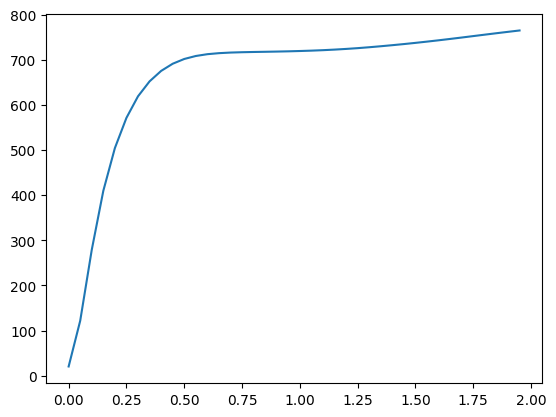

In [176]:
alphas = list(torch.arange(0, 2, 0.05).numpy())
len(alphas), len(losses)

plt.plot(alphas, losses)